In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from utils import get_data, \
    calculate_th, \
    get_crossing_threshold, \
    get_true_not_crossing_thrushold, \
    get_false_not_crossing_thrushold, \
    get_data_of_second_dataset
from prediction_uncertainty_model import PredictionIntervalModel
from explainer_model import ExplanationClassifier

In [20]:
data, target = get_data_of_second_dataset() # get_data()

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=.4, # 1 - (1- 0.33) /2,
                                                    random_state=75)

X_train, X_train_1, y_train, y_train_1 = train_test_split(X_train,
                                                    y_train,
                                                    test_size=.5, #(1- 0.33) /2,
                                                    random_state=75)

In [21]:
X_test.shape[0]

539318

In [22]:
th = calculate_th(target[['ber', 'class']], 'ber')

In [23]:
model_1 = PredictionIntervalModel(th)

In [24]:
model_1.models

{'y_lower': HistGradientBoostingRegressor(learning_rate=0.2, loss='quantile', max_depth=10,
                               max_iter=150, min_samples_leaf=5, quantile=0.025,
                               random_state=75),
 'y_upper': HistGradientBoostingRegressor(learning_rate=0.2, loss='quantile', max_depth=10,
                               max_iter=150, quantile=0.975, random_state=75),
 'y_pred': HistGradientBoostingRegressor(learning_rate=0.2, max_depth=10, max_iter=50,
                               random_state=75)}

In [25]:
model_1.fit(X_train, y_train['ber'].values)

In [26]:
model_1_prediction_df = model_1.prediction_df(X_train_1, y_train_1['ber'])

In [27]:
crossing_outcome = get_crossing_threshold(model_1_prediction_df, th)
true_uncrossing_outcome = get_true_not_crossing_thrushold(model_1_prediction_df, th)
false_uncrossing_outcome = get_false_not_crossing_thrushold(model_1_prediction_df, th)

In [30]:
print(f'crossing outcome: {(len(crossing_outcome) / len(model_1_prediction_df)) * 100:.2f}%\n' \
f'uncrossing outcome (true prediction): {(len(true_uncrossing_outcome) / len(model_1_prediction_df)) * 100:.2f}%\n' \
f'uncrossing outcome (false prediction): {(len(false_uncrossing_outcome) / len(model_1_prediction_df)) * 100:.2f}%')

crossing outcome: 7.10%
uncrossing outcome (true prediction): 92.90%
uncrossing outcome (false prediction): 0.00%


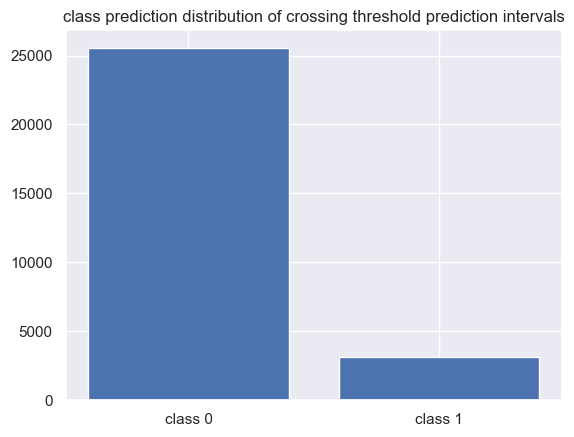

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

_, size_of_groups = np.unique(target.loc[crossing_outcome.index, 'class'], return_counts=True)

fig = plt.figure()
plt.bar([0, 1], size_of_groups)
plt.title("class prediction distribution of crossing threshold prediction intervals")
plt.xticks([0, 1], ["class 0", "class 1"])
plt.show()

fig.savefig("./cache/class_prediction_distribution_of_crossing_pi.png")

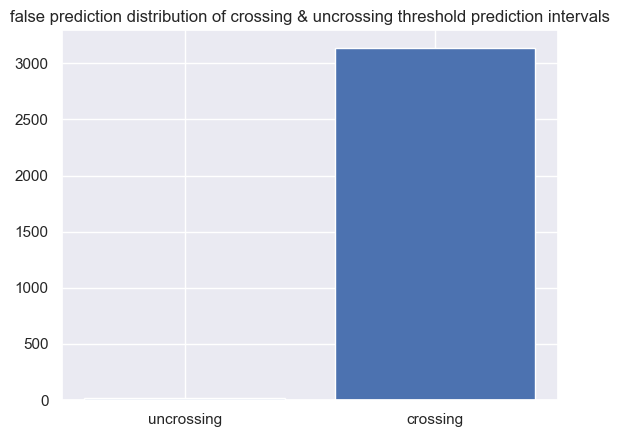

In [32]:
import matplotlib.pyplot as plt

size_of_groups = [len(false_uncrossing_outcome), size_of_groups[1]]

plt.close(fig)
fig = plt.figure()

plt.bar([0, 1], size_of_groups)
plt.xticks([0, 1], ["uncrossing", "crossing"])
plt.title("false prediction distribution of crossing & uncrossing threshold prediction intervals")
plt.show()

fig.savefig("./cache/false_prediction_distribution_of_crossing_and_uncrossing_pi.png")

In [33]:
from visualisation import plot_predictions

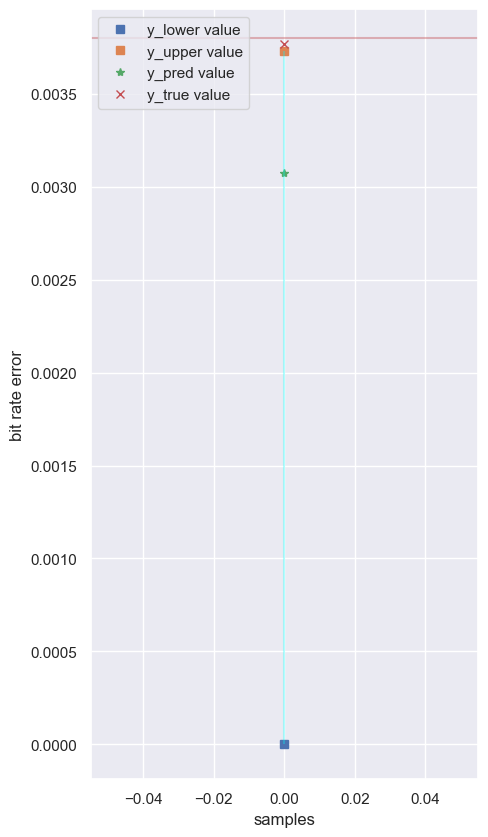

In [34]:
fig = plot_predictions(true_uncrossing_outcome.sort_values(by=['y_true'], ascending=False), th, show_only=1, figSize=(5, 10))

# fig.savefig("./cache/pi_plot_true_uncrossing.svg", dpi=300)

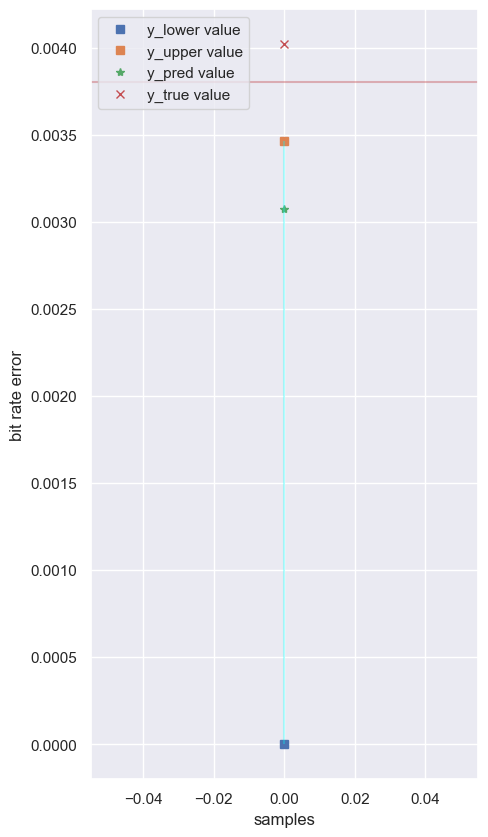

In [35]:
fig = plot_predictions(false_uncrossing_outcome.sort_values(by=['y_true'], ascending=False), th, show_only=1, figSize=(5, 10))

fig.savefig("./cache/pi_plot_false_uncrossing.svg", dpi=300)

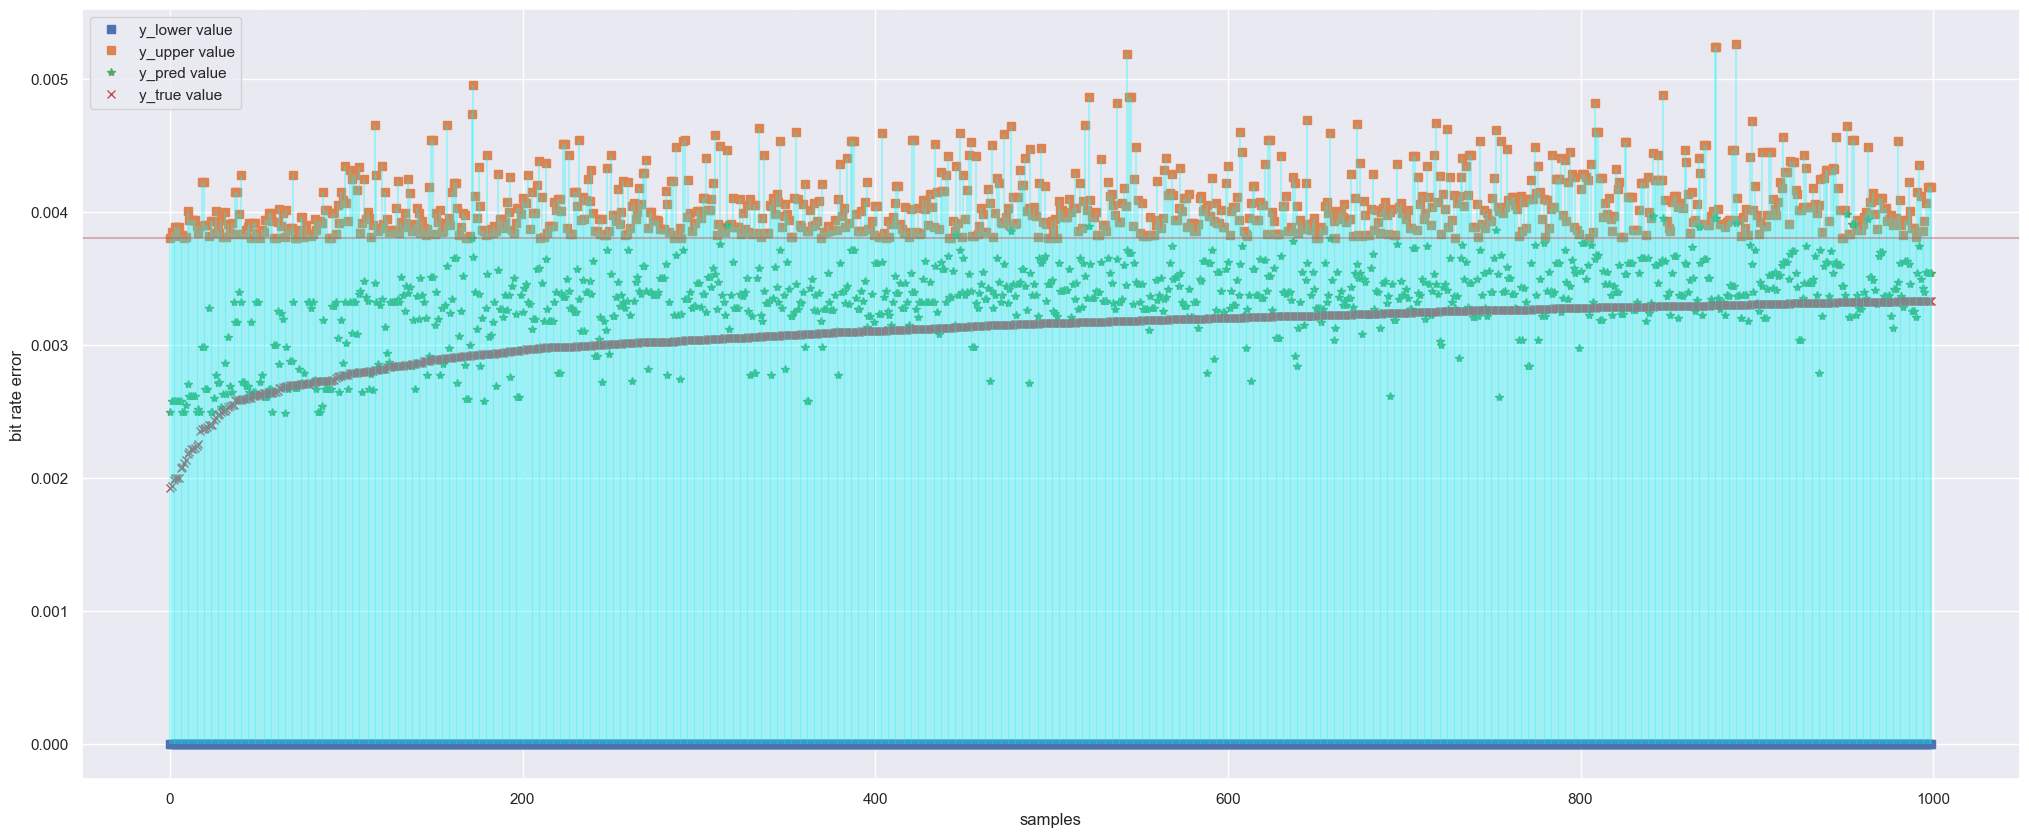

In [53]:
fig = plot_predictions(crossing_outcome.sort_values(by=['y_true'], ascending=True), th, show_only=1000, figSize=(25, 10))

fig.savefig("./cache/pi_plot_crossing.svg", dpi=300)

In [37]:
model_2 = ExplanationClassifier(model=model_1.models['y_pred'])
model_2_1 = ExplanationClassifier(model=model_1.models['y_pred'], include_original_features=True)

In [38]:
model_2.fit(X_train_1[X_train_1.index.isin(crossing_outcome.index)], ((crossing_outcome['y_pred'] < th).astype(int).values == (crossing_outcome['y_true'] < th).astype(int).values).astype(int))

model_2_1.fit(X_train_1[X_train_1.index.isin(crossing_outcome.index)], ((crossing_outcome['y_pred'] < th).astype(int).values == (crossing_outcome['y_true'] < th).astype(int).values).astype(int))

In [39]:
def predict(x):
    model_1_output = model_1.predict(x)

    assert len(model_1_output) == len(x)
    model_1_output.index = x.index

    model_1_output_crossing_outcome = get_crossing_threshold(model_1_output, th)
    assert len(model_1_output_crossing_outcome) < len(x)

    assert len(x[x.index.isin(model_1_output_crossing_outcome.index)]) == len(model_1_output_crossing_outcome)
    model_2_output = model_2.predict(x[x.index.isin(model_1_output_crossing_outcome.index)])
    model_2_1_output = model_2_1.predict(x[x.index.isin(model_1_output_crossing_outcome.index)])

    return model_2_output, model_2_1_output, model_1_output, model_1_output_crossing_outcome

In [40]:
pred_2, pred_2_1, pred_1, cross = predict(X_test)

In [41]:
df1 = pred_1.copy()

df1['y_true'] = y_test['ber']
df1['class'] = y_test['class'].astype(int)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539318 entries, 680196 to 197093
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   y_lower  539318 non-null  float64
 1   y_upper  539318 non-null  float64
 2   y_pred   539318 non-null  float64
 3   y_true   539318 non-null  float64
 4   class    539318 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 22.6 MB


In [42]:
len(df1[df1.index.isin(cross.index)]), len(pred_2)

(38283, 38283)

In [43]:
cf_model_1 = confusion_matrix(df1[~df1.index.isin(cross.index)]['y_pred'] < th, df1[~df1.index.isin(cross.index)]['class'])
cf_model_1

array([[     0,      0],
       [    17, 501018]], dtype=int64)

In [44]:
y_tmp = y_test.copy()

y_tmp.index = pred_1.index

In [45]:
cf_model_2 = confusion_matrix(pred_2, (df1[df1.index.isin(cross.index)]['y_pred'] < th).astype(int) == (df1[df1.index.isin(cross.index)]['class']).astype(int).values)
cf_model_2

array([[  859,   393],
       [  939, 36092]], dtype=int64)

In [46]:
cf_model_2_1 = confusion_matrix(pred_2_1, (df1[df1.index.isin(cross.index)]['y_pred'] < th).astype(int) == (df1[df1.index.isin(cross.index)]['class']).astype(int).values)
cf_model_2_1

array([[  922,   273],
       [  876, 36212]], dtype=int64)

In [47]:
print(classification_report(pred_2, (df1[df1.index.isin(cross.index)]['y_pred'] < th).astype(int) == (df1[df1.index.isin(cross.index)]['class']).astype(int).values))

              precision    recall  f1-score   support

           0       0.48      0.69      0.56      1252
           1       0.99      0.97      0.98     37031

    accuracy                           0.97     38283
   macro avg       0.73      0.83      0.77     38283
weighted avg       0.97      0.97      0.97     38283



In [48]:
print(classification_report(pred_2_1, (df1[df1.index.isin(cross.index)]['y_pred'] < th).astype(int) == (df1[df1.index.isin(cross.index)]['class']).astype(int).values))

              precision    recall  f1-score   support

           0       0.51      0.77      0.62      1195
           1       0.99      0.98      0.98     37088

    accuracy                           0.97     38283
   macro avg       0.75      0.87      0.80     38283
weighted avg       0.98      0.97      0.97     38283



model 1 cf_matrix

In [49]:
confusion_matrix(pred_1['y_pred'] < th, y_test['class'])

array([[ 32875,    529],
       [  1286, 504628]], dtype=int64)

In [50]:
print(classification_report(pred_1['y_pred'] < th, y_test['class']))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97     33404
        True       1.00      1.00      1.00    505914

    accuracy                           1.00    539318
   macro avg       0.98      0.99      0.99    539318
weighted avg       1.00      1.00      1.00    539318



In [51]:
X_test.shape, X_train.shape, X_train_1.shape, len(pred_2_1)

((539318, 32), (404487, 32), (404488, 32), 38283)